In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import plotly.offline
from plotly.subplots import make_subplots
import plotly.express as px
from sklearn.preprocessing import MinMaxScaler

from pptoolbox.platform.preprocessing import preprocess_v2
from pptoolbox.preprocessing import SNV, MSC, SavitzkyGolay, Detrend
from pptoolbox.visualization import (plot_spectra, plot_loadings, plot_scree, fit_pca,
                                               generate_pc_df, plot_svp, initialize_theme, spectral_vector_properties)


from sklearn.feature_selection import f_classif, mutual_info_classif, chi2

from pathlib import Path

# import

In [2]:
pulldate = "250318"

datafolder_path = Path ("../data/")
raw_csv = datafolder_path / f"raw/spectra_{pulldate}.csv"
spectra_df = pd.read_csv(raw_csv)

spectra_df.shape

(252, 35)

In [43]:
spectra_df['lot_id'].nunique()

36

In [3]:
spectra_df.columns

Index(['lot_id', 'active', 'analyzer_id', 'raw_data_mini', 'raw_data_neo',
       'company_id', 'dark_ref_data_mini', 'dark_ref_data_neo',
       'dark_ref_scan_time', 'date_scanned', 'detector_temp', 'frame_data',
       'healthy', 'id', 'integration_time', 'integration_time_neo', 'name',
       'scope_data_mini', 'scope_data_neo', 'spectrometer_temp_mini',
       'spectrometer_temp_neo', 'user_id', 'version', 'white_ref_data_mini',
       'white_ref_data_neo', 'white_ref_scan_time', 'raw_data',
       'dark_ref_data', 'white_ref_data', 'scope_data', 'specimen_id',
       'lot_name', 'analyser_id', 'product_id', 'product_name'],
      dtype='object')

In [4]:
spectra_df = spectra_df.rename(columns={'calc_data_mini':'raw_data_mini','calc_data_neo':'raw_data_neo'})
spectra_df['raw_data'] = np.nan

spectra_df_og = spectra_df.copy(deep=True)
spectra_df.head()

,lot_id,active,analyzer_id,raw_data_mini,raw_data_neo,company_id,dark_ref_data_mini,dark_ref_data_neo,dark_ref_scan_time,date_scanned,...,white_ref_scan_time,raw_data,dark_ref_data,white_ref_data,scope_data,specimen_id,lot_name,analyser_id,product_id,product_name
0,91527,1,105,"[{""wavelength"": 290.0734558105469, ""reflectanc...","[{""wavelength"": 926.3883666992188, ""reflectanc...",1328,"[-4.8458027839660645, -2.77597713470459, -0.72...","[34.36601638793945, 37.8487663269043, 28.56518...",1740465715,1740466115,...,1740465734,NaN,NaN,NaN,NaN,540937,P1_A_r1,105,6794,P1
1,91527,1,105,"[{""wavelength"": 290.0734558105469, ""reflectanc...","[{""wavelength"": 926.3883666992188, ""reflectanc...",1328,"[-4.8458027839660645, -2.77597713470459, -0.72...","[34.36601638793945, 37.8487663269043, 28.56518...",1740465715,1740466154,...,1740465734,NaN,NaN,NaN,NaN,540938,P1_A_r1,105,6794,P1
2,91527,1,105,"[{""wavelength"": 290.0734558105469, ""reflectanc...","[{""wavelength"": 926.3883666992188, ""reflectanc...",1328,"[-4.8458027839660645, -2.77597713470459, -0.72...","[34.36601638793945, 37.8487663269043, 28.56518...",1740465715,1740466214,...,1740465734,NaN,NaN,NaN,NaN,540939,P1_A_r1,105,6794,P1
3,91527,1,105,"[{""wavelength"": 290.0734558105469, ""reflectanc...","[{""wavelength"": 926.3883666992188, ""reflectanc...",1328,"[-4.8458027839660645, -2.77597713470459, -0.72...","[34.36601638793945, 37.8487663269043, 28.56518...",1740465715,1740466253,...,1740465734,NaN,NaN,NaN,NaN,540940,P1_A_r1,105,6794,P1
4,91527,1,105,"[{""wavelength"": 290.0734558105469, ""reflectanc...","[{""wavelength"": 926.3883666992188, ""reflectanc...",1328,"[-4.8458027839660645, -2.77597713470459, -0.72...","[34.36601638793945, 37.8487663269043, 28.56518...",1740465715,1740466299,...,1740465734,NaN,NaN,NaN,NaN,540941,P1_A_r1,105,6794,P1


In [5]:
info_df = spectra_df[['lot_id', 'lot_name']].copy(deep=True)

# info_df['scan_date'] = pd.to_datetime(info_df['date_scanned'], unit='s')
# info_df['scan_date'] = info_df['scan_date'].dt.date

concentrations = {
    'A' : 0,
    'B' : 0.5,
    'C' : 1,
    'D' : 1.5,
    'E' : 2,
    'F' : 3,
    'G' : 4,
    'H' : 5,
}

# Extract middle part and map to concentration
info_df['concentration'] = info_df['lot_name'].str.split('_').str[1].map(concentrations)

info_df = info_df.rename(columns={
    'lot_name':'Lot_Name',
    'date_scanned':'Date_Scanned',
    })

info_df = info_df.drop_duplicates()
info_df

,lot_id,Lot_Name,concentration
0,91527,P1_A_r1,0.0
7,91529,P1_C_r1,1.0
14,91528,P1_B_r1,0.5
21,91540,P1_B_r2,0.5
28,91539,P1_A_r2,0.0
35,91541,P1_C_r2,1.0
36,91552,P1_B_r3,0.5
43,91551,P1_A_r3,0.0
50,91531,P1_E_r11,2.0
57,91532,P1_E_r12,2.0


# preprocess

In [6]:
X_visnir, X_exnir, y, datatype = preprocess_v2(spectra_df, info_df)

In [7]:
display(X_visnir.head())
display(X_exnir.head())
display(y.head())

,480.0,483.0,486.0,489.0,492.0,495.0,498.0,501.0,504.0,507.0,...,1023.0,1026.0,1029.0,1032.0,1035.0,1038.0,1041.0,1044.0,1047.0,1050.0
lot_id,,,,,,,,,,,,,,,,,,,,,
91527,22.069518,22.246192,22.419267,22.589519,22.751212,22.943959,23.144121,23.341750,23.506315,23.715353,...,65.904050,66.144234,66.301992,66.345038,66.428768,66.178226,66.467123,66.264240,67.149633,66.590767
91527,22.855043,23.016427,23.209194,23.354054,23.521216,23.707513,23.889610,24.098404,24.259482,24.477907,...,64.750728,65.048425,65.351455,65.091692,65.304253,65.261237,65.442815,65.393283,65.727469,65.432675
91527,22.117318,22.282498,22.467532,22.622650,22.763972,22.962194,23.137921,23.341830,23.502978,23.691508,...,62.458336,62.705757,62.925192,62.713300,63.014791,62.674394,63.178599,62.983528,63.324862,63.318815
91527,20.792785,20.946661,21.127535,21.265385,21.423515,21.589566,21.761878,21.947080,22.092057,22.294003,...,59.528846,59.797909,59.927250,59.768916,60.138814,59.846436,60.234065,60.011161,60.432261,60.312748
91527,22.255597,22.418279,22.575030,22.733676,22.892295,23.079903,23.270081,23.472066,23.632071,23.847400,...,60.466476,60.801852,60.894618,60.672412,61.053564,60.811595,61.290679,60.957733,61.320888,61.206307


,975.0,984.0,993.0,1002.0,1011.0,1020.0,1029.0,1038.0,1047.0,1056.0,...,1569.0,1578.0,1587.0,1596.0,1605.0,1614.0,1623.0,1632.0,1641.0,1650.0
lot_id,,,,,,,,,,,,,,,,,,,,,
91527,63.297490,62.928649,63.857088,64.213072,64.441747,64.717251,65.101422,65.519466,65.989651,66.461215,...,40.621097,40.616205,40.926229,41.670785,42.632615,43.577830,44.488290,45.386627,46.130488,46.722670
91527,64.658956,64.141005,65.270795,65.624604,65.829462,66.086090,66.463386,66.899173,67.392845,67.883919,...,38.830163,38.782359,39.101798,39.922694,41.002723,42.074009,43.106190,44.140649,44.957288,45.616904
91527,58.947327,58.558718,59.443455,59.747607,59.933324,60.166187,60.499530,60.865946,61.279141,61.697377,...,37.678031,37.675500,37.965474,38.668207,39.575213,40.476312,41.339607,42.193140,42.891716,43.457553
91527,57.860478,57.364413,58.366919,58.664235,58.821459,59.029826,59.342134,59.707713,60.131626,60.543429,...,34.762540,34.724430,35.011361,35.747263,36.714843,37.669988,38.599934,39.530165,40.267717,40.864879
91527,58.031033,57.651482,58.539628,58.856971,59.047446,59.280438,59.610627,59.976041,60.400746,60.815795,...,36.372192,36.369774,36.657179,37.365186,38.282372,39.193494,40.072983,40.951146,41.667276,42.246590


,Lot_Name,concentration
lot_id,,
91527,P1_A_r1,0.0
91527,P1_A_r1,0.0
91527,P1_A_r1,0.0
91527,P1_A_r1,0.0
91527,P1_A_r1,0.0


In [8]:
X_visnir.shape, X_exnir.shape, y.shape

((252, 191), (252, 76), (252, 2))

In [9]:
label_df = pd.merge(y.reset_index().drop_duplicates(), spectra_df[['lot_name','date_scanned']], left_on='Lot_Name', right_on='lot_name', how='left')
label_df = label_df.drop(columns=['lot_name'])
label_df = label_df.set_index('lot_id')
label_df_og = label_df.copy(deep=True)
label_df

,Lot_Name,concentration,date_scanned
lot_id,,,
91527,P1_A_r1,0.0,1740466115
91527,P1_A_r1,0.0,1740466154
91527,P1_A_r1,0.0,1740466214
91527,P1_A_r1,0.0,1740466253
91527,P1_A_r1,0.0,1740466299
...,...,...,...
91562,P1_H_r3,5.0,1740987543
91562,P1_H_r3,5.0,1740987577
91562,P1_H_r3,5.0,1740987651


In [10]:
label_df = label_df_og.copy(deep=True)

In [11]:
label_df['Date_Scanned'] = pd.to_datetime(label_df['date_scanned'], unit='s')
label_df['Date_Scanned'] = label_df['Date_Scanned'].dt.date
label_df = label_df.drop(columns=['date_scanned', 'Lot_Name'])
label_df.head()

,concentration,Date_Scanned
lot_id,,
91527,0.0,2025-02-25
91527,0.0,2025-02-25
91527,0.0,2025-02-25
91527,0.0,2025-02-25
91527,0.0,2025-02-25


In [12]:
label_type_list = ['clf' if label_df[col].dtypes == 'object' else 'reg' for col in label_df.columns]
param_label_map = dict(zip(label_df.columns, label_type_list))
param_label_map

{'concentration': 'reg', 'Date_Scanned': 'clf'}

In [13]:
spectral_ranges = {
    'visnir':{
        'spectrum': X_visnir
    },
    'exnir':{
        'spectrum': X_exnir
    }
}

# Check for Outliers

In [14]:
label = 'Coffee'

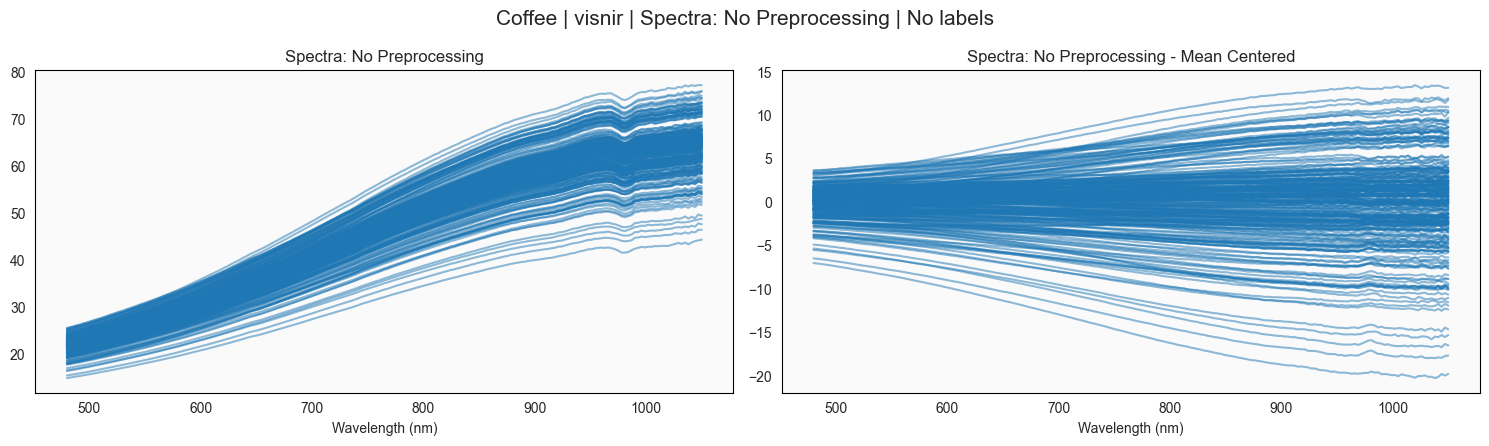

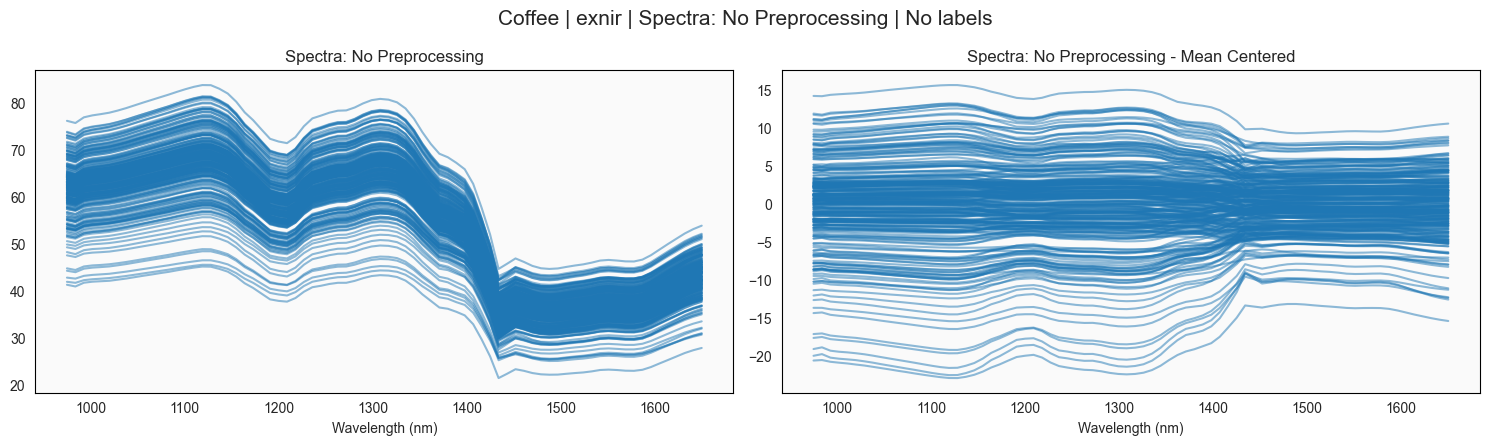

In [15]:
PREPROCESSING = 'No Preprocessing'
SAMPLE_TYPE = f'{label}'
cmap=sns.color_palette()

for spectral_range in spectral_ranges:
    SAMPLE_TYPE = f'{label} | {spectral_range}'
    raw_df = spectral_ranges[spectral_range]['spectrum']

    plot_spectra(raw_df, labels=None,
             spec_prep=PREPROCESSING,
             sample_type=SAMPLE_TYPE,
             cmap=cmap);

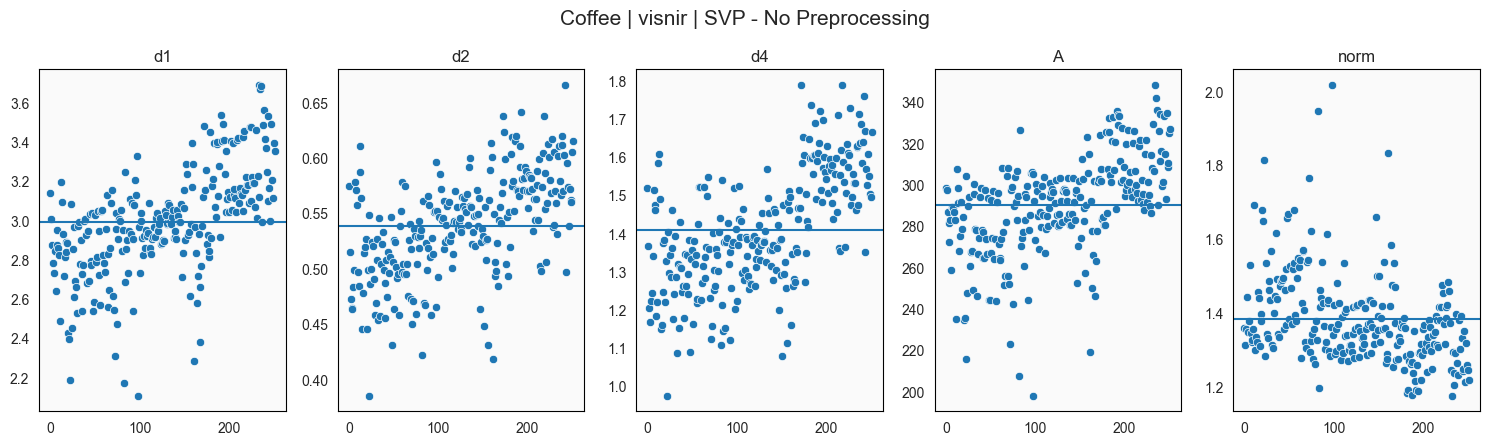

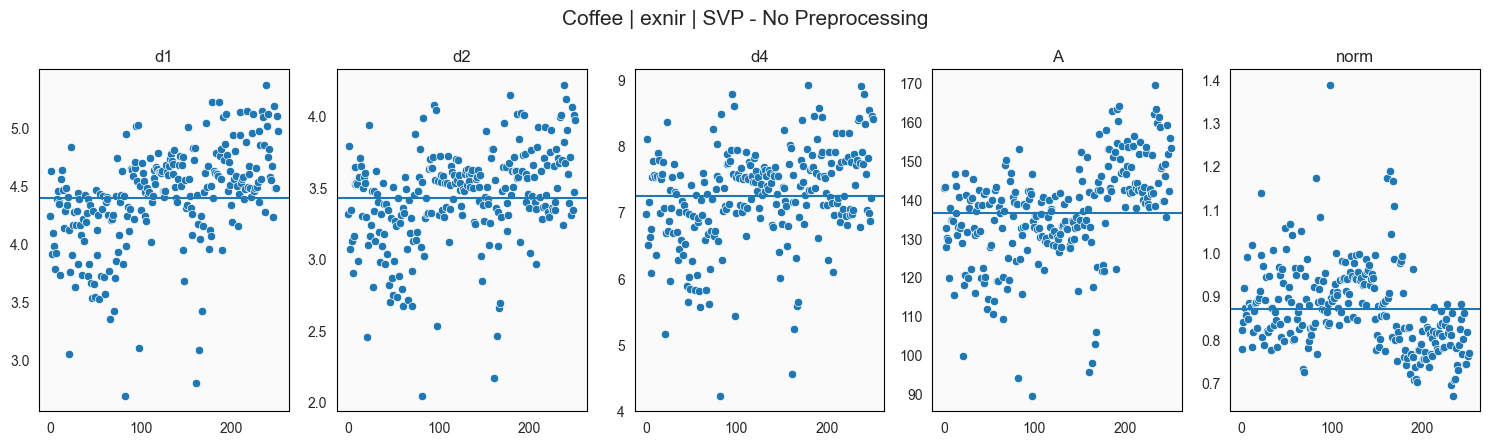

In [16]:
for spectral_range in spectral_ranges:
    SAMPLE_TYPE = f'{label} | {spectral_range}'
    raw_df = spectral_ranges[spectral_range]['spectrum']
    plot_svp(raw_df, title=f'{label} | {spectral_range} | SVP - No Preprocessing')

## identify outlier sample

In [17]:
cutoff = {
    "visnir":{
        "maxval":1.6,
        "minval":1.1
    },
    "exnir":{
        "maxval":1,
        "minval":0.6
    }
}

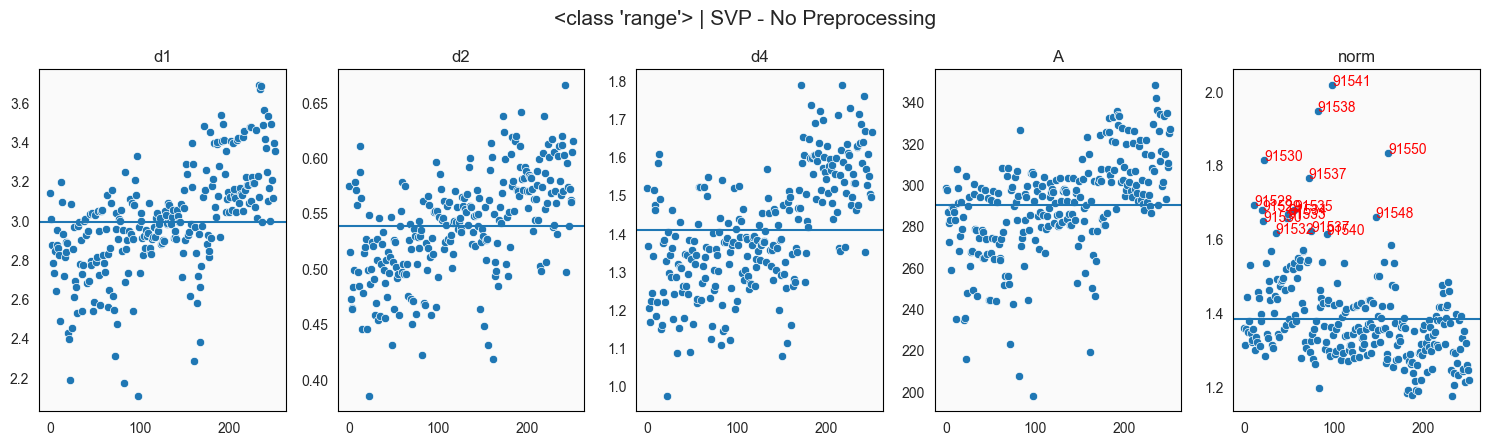

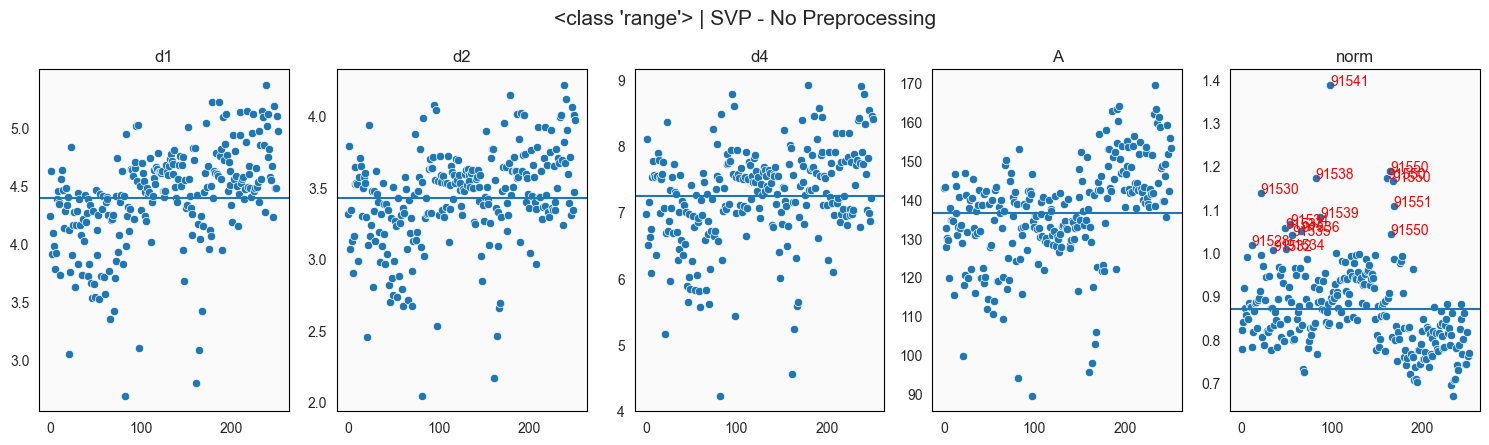

In [19]:
for spectral_range in spectral_ranges:
    SAMPLE_TYPE = f'{label} | {spectral_range}'
    raw_df = spectral_ranges[spectral_range]['spectrum']
    plot_svp(raw_df, title=f'{range} | SVP - No Preprocessing')

    raw_df_check = pd.DataFrame(raw_df)
    svp_arr = spectral_vector_properties(raw_df_check, True)

    #metrics cutoff
    metrics = {
        0 : 'd1',
        1 : 'd2',
        2 : 'd4',
        3 : 'A',
        4 : 'norm'
    }
    choice = 4
    maxval, minval = cutoff[spectral_range]['maxval'], cutoff[spectral_range]['minval']

    norm_data = svp_arr[metrics[choice]]
    norm_ax = plt.gcf().axes[choice]

    for idx in range(len(norm_data)):
        if norm_data.iloc[idx] < minval or norm_data.iloc[idx] > maxval:  
            norm_ax.text(idx, norm_data.iloc[idx], norm_data.index[idx], 
                        fontsize=10, color='red')

    plt.draw()

False    237
True      15
Name: norm, dtype: int64

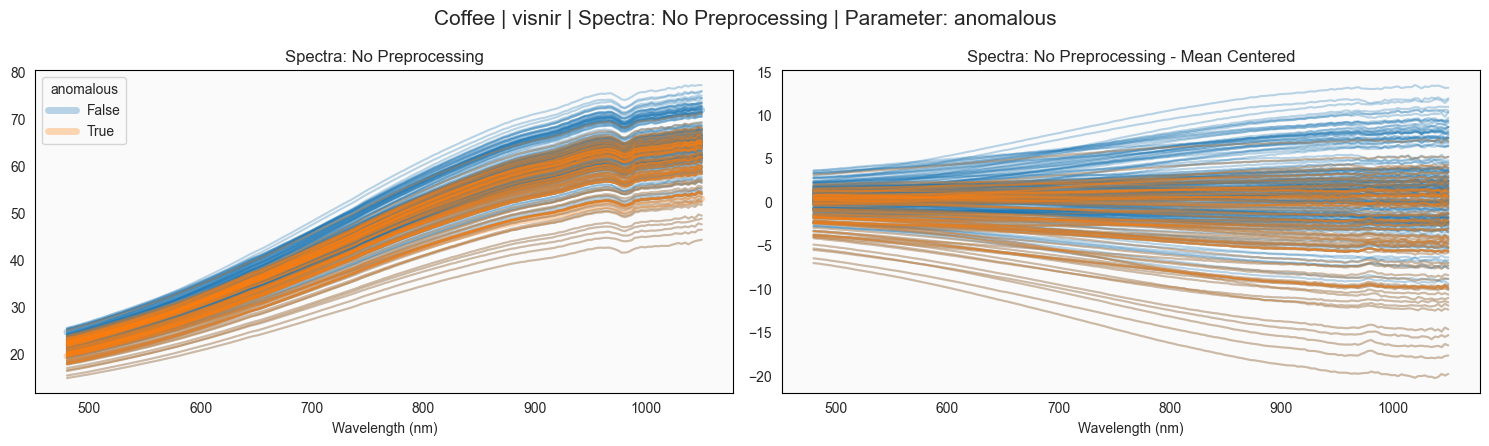

False    236
True      16
Name: norm, dtype: int64

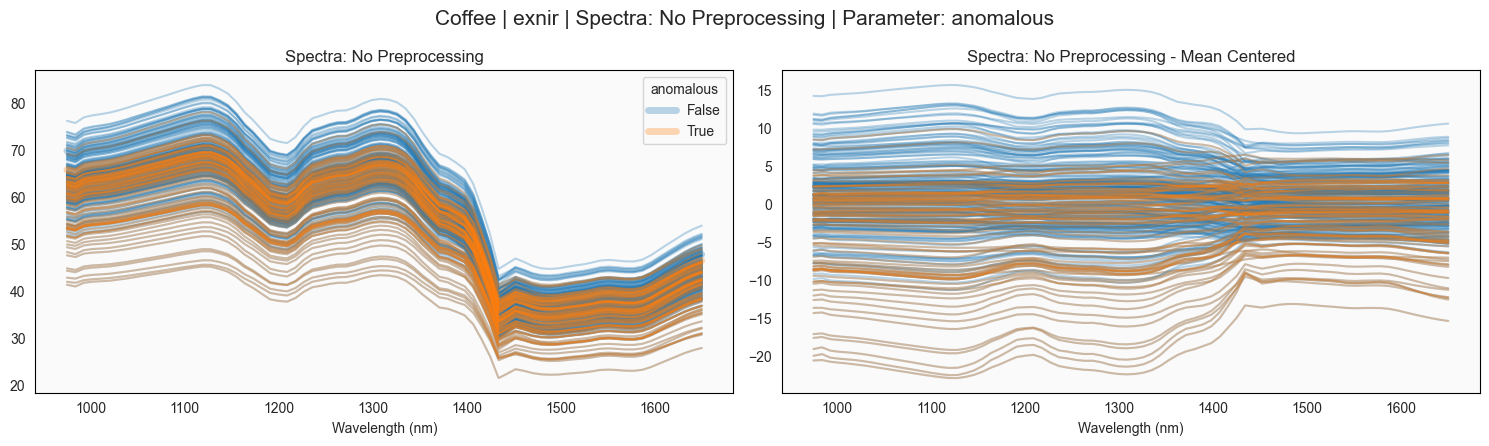

In [20]:
for spectral_range in spectral_ranges:
    SAMPLE_TYPE = f'{label} | {spectral_range}'
    raw_df = spectral_ranges[spectral_range]['spectrum']

    maxval, minval = cutoff[spectral_range]['maxval'], cutoff[spectral_range]['minval']

    raw_df_check = pd.DataFrame(raw_df)
    svp_arr = spectral_vector_properties(raw_df_check, True)

    anomalous_mask = (svp_arr[metrics[choice]] < minval) | (svp_arr[metrics[choice]] > maxval)
    display(anomalous_mask.value_counts())

    spectral_ranges[spectral_range]['anomalous_mask'] = anomalous_mask

    # add a new column in check_df to label anomalous samples
    check_df = raw_df_check.copy(deep=True)
    check_df['anomalous'] = anomalous_mask

    plot_spectra(raw_df_check, labels=check_df[['anomalous']],
                spec_prep=PREPROCESSING,
                sample_type=SAMPLE_TYPE,
                cmap=cmap)
    plt.show()
    plt.close()

In [21]:
# check which parts of the masks are different
diff_mask = spectral_ranges['visnir']['anomalous_mask'] != spectral_ranges['exnir']['anomalous_mask']
diff_mask.value_counts()

False    239
True      13
Name: norm, dtype: int64

In [22]:
# create a new mask that is True if either of the masks is True
combined_mask = spectral_ranges['visnir']['anomalous_mask'] | spectral_ranges['exnir']['anomalous_mask']
combined_mask.value_counts()    

False    230
True      22
Name: norm, dtype: int64

## filter outliers

In [44]:
cleaned_spectra = {}
output_dir = Path(f"../data/processed/")
output_dir.mkdir(exist_ok=True, parents=True)

for spectral_range in spectral_ranges:
    SAMPLE_TYPE = f'{label} | {spectral_range}'
    selected_df = spectral_ranges[spectral_range]['spectrum']

    print(f"Original shape of {spectral_range} data: {selected_df.shape}")
    cleaned_df = selected_df[~combined_mask]
    print(f"Cleaned shape of {spectral_range} data: {cleaned_df.shape}")

    cleaned_df.to_csv(output_dir/f"cleaned_{spectral_range}_input.csv")
    spectral_ranges[spectral_range]['cleaned_spectrum'] = cleaned_df

cleaned_labels = label_df[~combined_mask]
cleaned_labels.to_csv(output_dir/f"cleaned_label.csv")

Original shape of visnir data: (252, 191)
Cleaned shape of visnir data: (230, 191)
Original shape of exnir data: (252, 76)
Cleaned shape of exnir data: (230, 76)


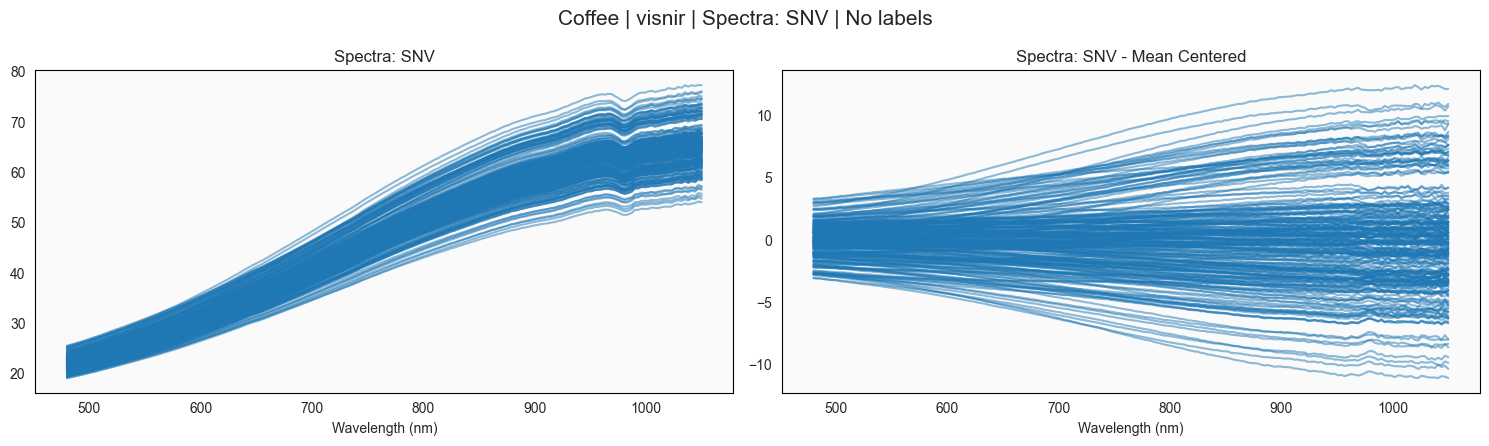

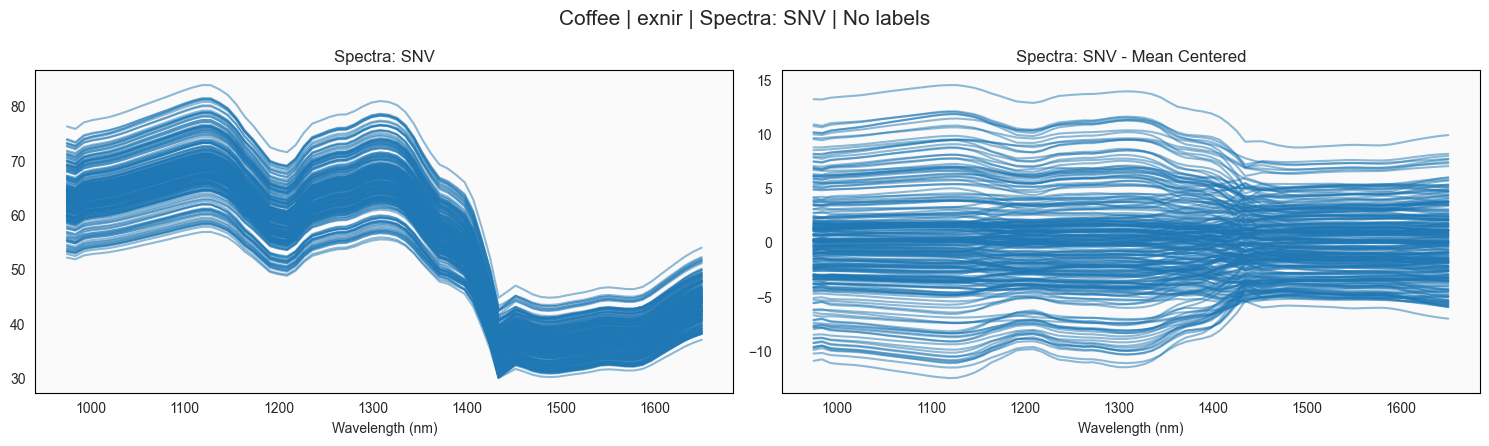

In [46]:
for spectral_range in spectral_ranges:
    SAMPLE_TYPE = f'{label} | {spectral_range}'
    raw_df = spectral_ranges[spectral_range]['cleaned_spectrum']

    plot_spectra(raw_df, labels=None,
             spec_prep=PREPROCESSING,
             sample_type=SAMPLE_TYPE,
             cmap=cmap);

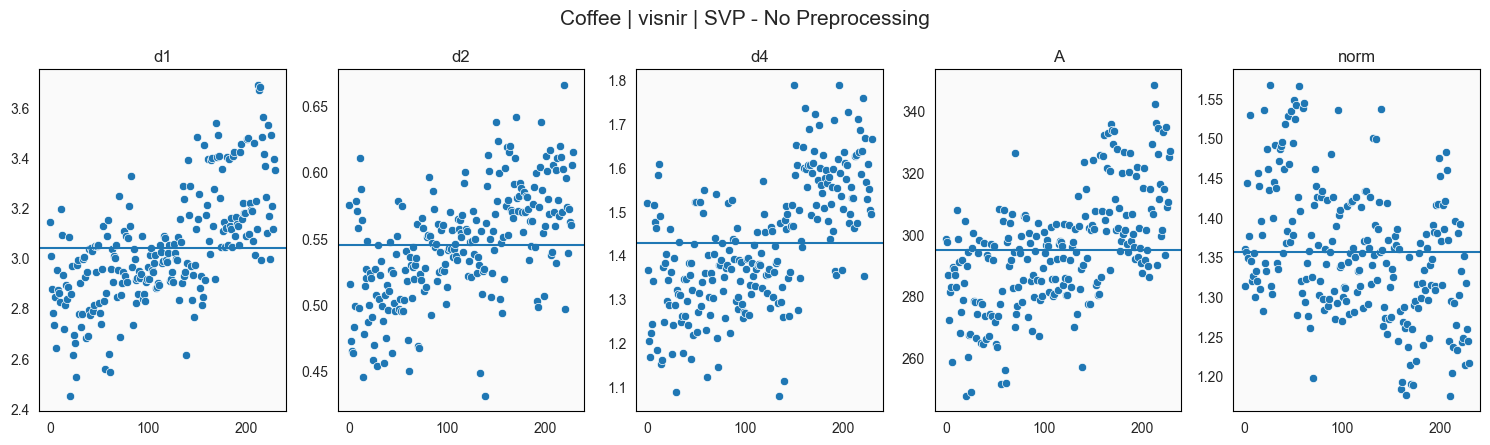

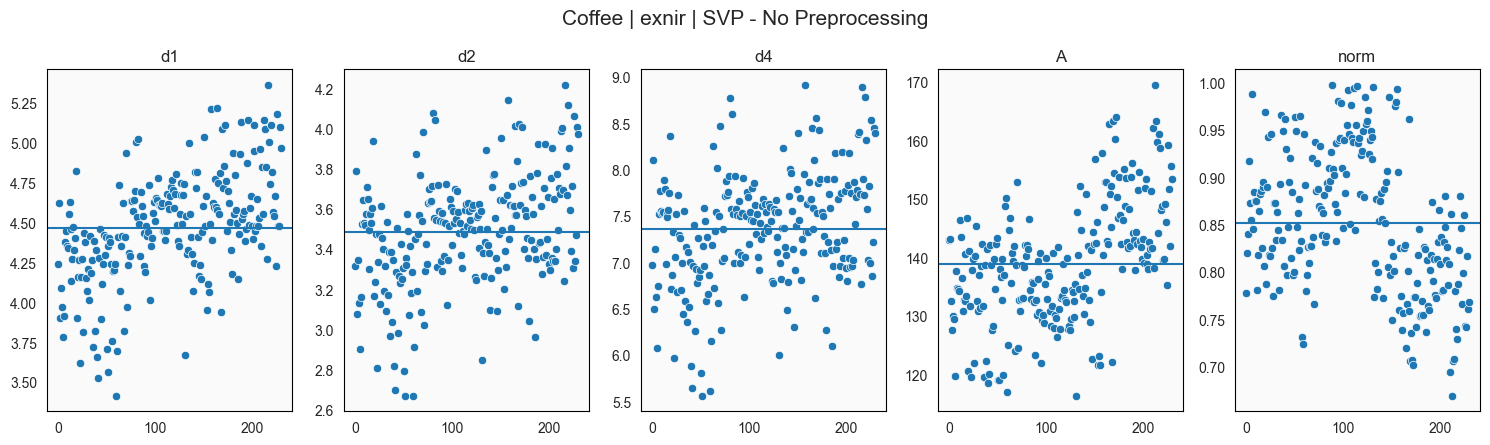

In [45]:
for spectral_range in spectral_ranges:
    SAMPLE_TYPE = f'{label} | {spectral_range}'
    raw_df = spectral_ranges[spectral_range]['cleaned_spectrum']
    plot_svp(raw_df, title=f'{label} | {spectral_range} | SVP - No Preprocessing')